# Toy Model

Below is a simple toy model to explore the impact of slope, scatter, and resolution on the stellar mass-halo mass (SMHM) relation, as well as on the halo occupation fraction. See a bug? Please [let me know](mailto:elaad.applebaum@gmail.com).

The [first section](#definitions) defines the functions that are used in the toy model. The [second section](#toymodel) combines all these functions into an interactive figure.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.optimize import curve_fit
from matplotlib.widgets import Slider, CheckButtons

%matplotlib notebook

## function definitions
<a id="definitions"></a>

The SMHM-related functions defined below are:
- `smhm`: the underlying broken power law SMHM
- `smhm_spread`: given an underlying SMHM, adds scatter (calculated in bins of halo and stellar mass)
- `num_halos`: given a power-law halo mass function, calculates the number of halos in different bins
- `num_galaxies`: given an SMHM relation, scatter, and halo mass function, calculates the number of galaxies present in bins of halo and stellar mass
- `refit_smhm`: refit the SMHM to galaxies that are above the resolution

There are also a few functions specifically for plotting:
- `calculate_rotation`: for plotting purposes, calculates the angle of rotation of a plotted line
- `adjust_checkbox`: this is to resize the checkbox

The hard-coded values and keyword arguments are based on the results of [our paper](INSERT ARXIV LINK).

In [2]:
def smhm(mh, alpha, m1=10, ms1=6.9):
    """Underlying power law SMHM, pinned at mhalo=m1 with mstar=ms1
    
    alpha controls the slope below m1. The slope is fixed at 1.9
        above m1
    
    mh : log halo masses
    alpha : slope of the SMHM
    
    returns : log stellar mass for each halo mass
    """
    mh = np.array(mh)
    ms = np.zeros(mh.shape)
    ms[mh <= m1] = alpha * (mh[mh <= m1] - m1) + ms1
    ms[mh > m1] = 1.9 * (mh[mh > m1] - m1) + ms1
    return ms

In [3]:
def smhm_spread(alpha, sigma, grow=False,
                m1=10, ms1=6.9,
                mhbins=np.linspace(8, 10, 31), 
                msbins=np.linspace(3, 9, 31),
                return_masses=False):
    """Given underlying SMHM relation, add scatter
    
    
    Calculate the fraction of galaxies residing in each mstar bin
        in a given mhalo bin, given scatter and underlying SMHM.
        i.e. in a given bin of mhalo, the total fraction adds to 1
        
    alpha : power law slope
    sigma : SMHM scatter
    grow : if True, sigma is actually gamma for growing scatter
    m1/ms1: normalization of SMHM (see `smhm`)
    mhbins : bins of (log) mhalo
    msbins : bins of (log) mstar
    return_masses : if true, also return the bins
        in which galaxy fractions are calculated
        
    returns : 2D array with fraction of galaxies in stellar mass bin
        for a given halo mass bin. 
        shape is (len(msbins) - 1, len(mhbins) - 1)
    """
    mhbins, msbins = np.array(mhbins), np.array(msbins)
    # the bin middles of halo mass used to calculate stellar mass
    mhsamp = 0.5 * (mhbins[1:] + mhbins[:-1])
    X, Y = np.meshgrid(mhsamp, msbins)
    if grow:  # not constant sigma, but dependent on halo mass
        sigma_spread = np.zeros(X.shape)
        sigma_spread[X > m1] = 0.3
        sigma_spread[X <= m1] = 0.3 + (m1 - X[X <= m1]) * sigma
        sigma = sigma_spread
    # if scatter is lognormally distributed, then the CDF of
    # the normal distribution (i.e. erf) gives the cumulative
    # fraction of galaxies at each stellar mass bin edge
    integral = 0.5 * (1 + erf((Y - smhm(X, alpha, m1, ms1)) 
                             / (sigma * np.sqrt(2))))
    # the diff of the CDF, then, gives the fraction of galaxies
    # in each bin
    if return_masses:
        return np.diff(integral, axis=0), mhbins, msbins
    else:
        return np.diff(integral, axis=0)

In [4]:
def num_halos(hmf_slope, n_tot, mhbins):
    """Calculate number of halos per bin with power law HMF
    
    hmf_slope : the power-law slope
    n_tot : the number of halos within max(mhbins) and min(mhbins)
    mhbins : the bins of log halo mass
    
    returns : number of halos per bin
    """
    mhbins = np.array(mhbins)
    # hmf_slope ~ dlogN/dlogM
    # so, dN/dlogM ~ hmf_slope - 1
    # so, in integral, end up with hmf_slope again
    const = n_tot * hmf_slope / ((10**mhbins.max())**hmf_slope 
                                 - (10**mhbins.min())**hmf_slope)
    return const / hmf_slope * np.diff((10**mhbins)**hmf_slope)

In [5]:
def num_galaxies(alpha, sigma, grow=False,
                 hmf_slope=None, 
                 n_tot=None, smhm_kwargs={}):
    """Caclulate the number of galaxies in each mhalo/mstar bin
    
    
    alpha : the slope
    sigma : the scatter
    grow : if True, sigma becomes gamma for growing scatter
    hmf_slope : slope of power law halo mass function
    n_tot : the total number of halos within the limits of the mhbins
    smhm_kwargs : keyword arguments passed to smhm_spread function
        
    returns : (halo bins, mstar bins, galaxy counts)
    """
    num, mh, ms = smhm_spread(alpha, sigma, grow=grow,
                              return_masses=True, **smhm_kwargs)
    num = num * num_halos(hmf_slope, n_tot, mh)
        
    return mh, ms, num

In [6]:
def calculate_rotation(xs, ys, ind, ax):
    """Return position and rotation of text label to align with plotted line
    
    This is general enough for lines that aren't straight, 
        so a bit overkill in this context
        
    xs, ys : the xy values of the plotted line
    ind : the index at which to calculate rotation
    ax : the axis object on which to calculate rotation
    y_offset : how much (in data units) to shift the text upwards
    """
    xs, ys = np.array(xs), np.array(ys)
    # calculate the angle
    rotation = np.arctan2((ys[ind + 1] - ys[ind - 1]), 
                           xs[ind + 1] - xs[ind - 1])
    xt, yt = xs[ind], ys[ind]
    # to degree
    rotation *= 180. / np.pi
    # convert to data coordinates
    rotation = ax.transData.transform_angles(np.array([rotation]), 
                                             np.array([[xt, yt]]))[0]
    return xt, yt, rotation

In [7]:
def adjust_checkbox(checkbox, x, y, side_length):
    """Resize the checkbox and move the label"""
    # change box size
    checkbox.rectangles[0].set_bounds(x, y, side_length, side_length)
    # change the size of the "X" when you check the box
    checkbox.lines[0][0].set_data([x, x + side_length], [y + side_length, y])
    checkbox.lines[0][1].set_data([x, x + side_length], [y, y + side_length])
    # reposition the label
    checkbox.labels[0].set_horizontalalignment('left')
    checkbox.labels[0].set_x(x + side_length * 1.5)
    return checkbox

In [8]:
def refit_smhm(mharray, msarray, numarray):
    """Refit the SMHM using only galaxies above stellar mass resolution
    
    mharray : the array of log halo mass bin edges
    msarray : the array of log stellar mass bin edges
    numarray : the number of galaxies in each 2D bin
    
    returns : the best-fit slope of the SMHM
    """
    X, Y = np.meshgrid(0.5 * (mharray[1:] + mharray[:-1]), 
                       0.5 * (msarray[1:] + msarray[:-1]))
    # ignore bins containing 0 galaxies in the fit, which would have
    # sigma = infinity
    x_to_fit, y_to_fit, num_to_fit = X.ravel(), Y.ravel(), numarray.ravel()
    mask = num_to_fit > 0
    # weight the value in each bin by the number of galaxies in the bin    
    popt, pcov = curve_fit(smhm, x_to_fit[mask], y_to_fit[mask], 1, 
                           sigma=1/np.sqrt(num_to_fit[mask]))
    return popt[0]

## The toy model
<a id="toymodel"></a>

<IPython.core.display.Javascript object>


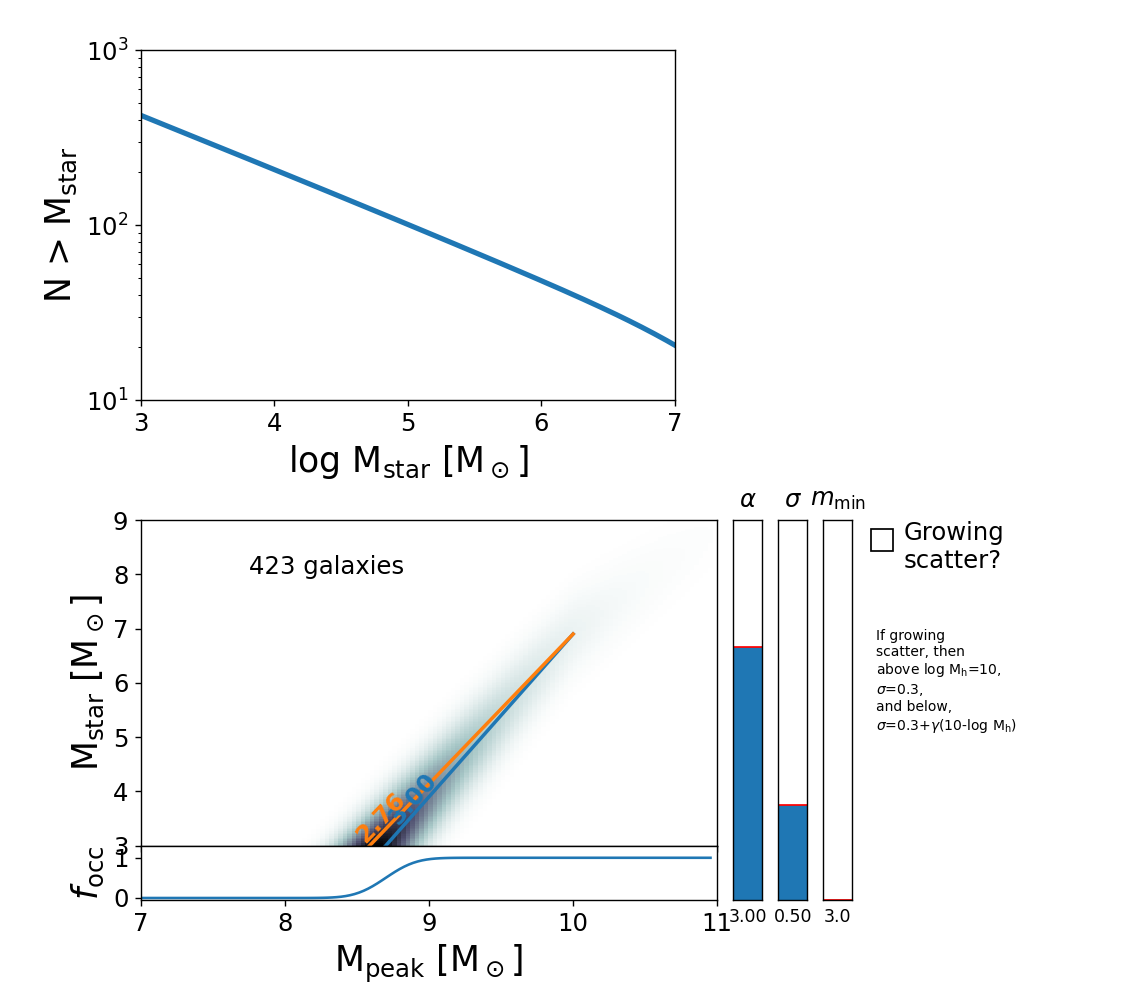

In [9]:
# set up the figure and axes
# ax is for the SMHM, ax2 is for the SMF, and the rest are self-explanatory
fig = plt.figure(figsize=(9, 8))
gs = fig.add_gridspec(3, 5, hspace=0, wspace=0.1, top=0.48, bottom=0.1,
                      width_ratios=[20, 1, 1, 1, 5], height_ratios=[1, 5, 1])
ax = fig.add_subplot(gs[:2, 0])
alphaax = fig.add_subplot(gs[:, 1])
sigax = fig.add_subplot(gs[:, 2])
minax = fig.add_subplot(gs[:, 3])
checkax = fig.add_subplot(gs[0, 4])

# set equal aspect ratio so the checkbox is square
checkax.set_aspect('equal', anchor='W')
checkax.axis('off')

# add explanation of the checkbox functionality
textax = fig.add_subplot(gs[1, 4])
textax.axis('off')
statement = 'If growing \nscatter, then\n'
statement += 'above log M$_\mathrm{h}$=10,\n'
statement += '$\sigma$=0.3,\nand below,\n'
statement += '$\sigma$=0.3+$\gamma$(10-log M$_\mathrm{h}$)'
textax.text(0.05, 0.8, 
            statement, fontsize=8,
            transform=textax.transAxes, va='top', ha='left')
foccax = fig.add_subplot(gs[2, 0], sharex=ax)

# fig.subplots_adjust(bottom=0.2)

# default values
alpha0 = 3
sigma0 = 0.5
mmin0 = 3
# this is False to start, but can be switched to True by
# clicking the checkbox
grow = False

# set up sliders and checkbox
alpha_slider = Slider(alphaax, r'$\alpha$', 1, 4, valfmt='%.2f',
                      orientation='vertical', valinit=alpha0)
sigma_slider = Slider(sigax, r'$\sigma$', 0, 2, valfmt='%.2f',
                      orientation='vertical', valinit=sigma0)
min_slider = Slider(minax, r'$m_\mathrm{min}$', 3, 6, valfmt='%.1f',
                    orientation='vertical', valinit=mmin0)
for slider in [alpha_slider, sigma_slider, min_slider]:
    slider.label.set_size(14)

check = CheckButtons(checkax, ['Growing\nscatter?'], actives=[grow])
# resize the checkbox
check = adjust_checkbox(check, 0.05,
                        check.rectangles[0].get_y(), 
                        0.4)
check.labels[0].set_size(14)

# calculate the number of galaxies per (log) halo mass - stellar mass bin
mh0, ms0, num0 = num_galaxies(alpha0, sigma0, grow=grow,
                              hmf_slope=-0.92, n_tot=14700, 
                              smhm_kwargs={'msbins':np.arange(mmin0, 10.5, 0.03125),
                                           'mhbins':np.arange(7, 11, 0.03125)})

p = ax.pcolormesh(mh0, ms0, num0, cmap='bone_r')

# set axis limits here so we can properly calculate the rotation
# for overplotting text in data units
ax.set_ylim(3, 9)
ax.set_xlim(7, 11)

# fit and plot the biased SMHM
alphafit = refit_smhm(mh0, ms0, num0)
xs = np.linspace(8, 10, 10)
l1, = ax.plot(xs, smhm(xs, alpha0), lw=2)
l2, = ax.plot(xs, smhm(xs, alphafit), lw=2)
# add the text labels
fontdict = {'weight':'bold', 'size':14, 'va':'center', 'ha':'center'}
x1, y1, rot1 = calculate_rotation(xs, smhm(xs, alpha0), 4, ax)
t1 = ax.text(x1, y1 + 0.3, f'{alpha0:.2f}', rotation=rot1, 
             color='C0', fontdict=fontdict)
x2, y2, rot2 = calculate_rotation(xs, smhm(xs, alphafit), 3, ax)
t2 = ax.text(x2, y2 + 0.3, f'{alphafit:.2f}', rotation=rot2,
             color='C1', fontdict=fontdict)

# calculate fraction of galaxies in 2D bins, instead of number of galaxies
# sum is the total occupation fraction for each halo bin
occnum0 = smhm_spread(alpha0, sigma0, grow=grow, mhbins=mh0, msbins=ms0)
ol, = foccax.plot(0.5 * (mh0[1:] + mh0[:-1]), occnum0.sum(axis=0))

# axis labels and properties
ax.tick_params('x', labelbottom=False)
foccax.set_xlabel('M$_\mathrm{peak}$ [M$_\odot$]', fontsize=20)
ax.set_ylabel('M$_\mathrm{star}$ [M$_\odot$]', fontsize=20)
ax.tick_params(labelsize=14)
foccax.tick_params(labelsize=14)
foccax.set_ylim(-0.05, 1.3)
foccax.set_ylabel('$f_\mathrm{occ}$', fontsize=20)

# add label for number of galaxies
tnum = ax.text(7.75, 8, f'{int(num0.sum())} galaxies', 
               fontsize=14)

# setting up the SMF axis and plotting the SMF
gs2 = fig.add_gridspec(1, 1, top=0.95, bottom=0.6, right=0.6)
ax2 = fig.add_subplot(gs2[0])

# SMF is the cumulative number of galaxies greater than a given mass
csmf = num0.sum(axis=1)[::-1].cumsum()[::-1]
lsmf, = ax2.plot(ms0[:-1], csmf, lw=3)

# labels and properties of the axis
ax2.set_yscale('log')
ax2.set_xlim([3, 7])
ax2.set_ylim([10, 1000])
ax2.set_xlabel('log M$_\mathrm{star}$ [M$_\odot$]', fontsize=20)
ax2.set_ylabel('N > M$_\mathrm{star}$', fontsize=20)
ax2.tick_params(labelsize=14)



def update(val):
    # essentially repeating same calculations as above, but instead of new plots,
    # just updating the data of the existing lines and objects
    mh, ms, num_square = num_galaxies(alpha_slider.val, sigma_slider.val, grow=grow,
                                      hmf_slope=-0.92, n_tot=14700, 
                                      smhm_kwargs={'msbins':np.arange(min_slider.val, 10.5, 0.03125),
                                                   'mhbins':np.arange(7, 11, 0.03125)})
    num = num_square.ravel()
    # anything below the resolution limit is zero now
    num_array = np.zeros(len(num0.ravel()))
    num_array[-len(num):] = num
    p.set_array(num_array)
    # same procedure as above
    # see above for detailed comments
    alphafit = refit_smhm(mh, ms, num)
    l1.set_ydata(smhm(xs, alpha_slider.val))
    l2.set_ydata(smhm(xs, alphafit))
    x1, y1, rot1 = calculate_rotation(xs, smhm(xs, alpha_slider.val), 4, ax)
    x2, y2, rot2 = calculate_rotation(xs, smhm(xs, alphafit), 3, ax)
    t1.set_x(x1)
    t1.set_y(y1 + 0.3)
    t2.set_x(x2)
    t2.set_y(y2 + 0.3)
    t1.set_text(f'{alpha_slider.val:.2f}')
    t2.set_text(f'{alphafit:.2f}')
    t1.set_rotation(rot1)
    t2.set_rotation(rot2)
    tnum.set_text(f'{int(num.sum())} galaxies')
    occnum = smhm_spread(alpha_slider.val, sigma_slider.val, 
                         grow=grow, mhbins=mh, msbins=ms)
    ol.set_ydata(occnum.sum(axis=0))
    lsmf.set_xdata(ms[:-1])
    lsmf.set_ydata(num_square.sum(axis=1)[::-1].cumsum()[::-1])

    fig.canvas.draw_idle()

def change_scatter(val):
    # if the checkbox is flipped, the meaning of the
    # `sigma_slider` changes, which means we also have to
    # change the global variable `grow`
    if check.get_status()[0]:
        label = r'$\gamma$'
        valinit = 0.3
        valmax = 1
    else:
        label = r'$\sigma$'
        valinit = 0.5
        valmax = 2
    global sigax
    global sigma_slider
    sigax.clear()
    # recreate sigma_slider with new labels and values
    sigma_slider.__init__(sigax, label, 0, 
                          valmax=valmax, valfmt='%.2f',
                          orientation='vertical', 
                          valinit=valinit)
    sigma_slider.label.set_size(14)
    sigma_slider.on_changed(update)
    global grow
    grow = check.get_status()[0]
    update(1)
    

alpha_slider.on_changed(update)
sigma_slider.on_changed(update)
min_slider.on_changed(update)
check.on_clicked(change_scatter)

plt.show()